In [1]:
from __future__ import print_function

import argparse
import datetime
import os
import random
import sys
import time
#from sdtw.dataset import load_ucr
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from distance_handler import get_distance_handler
from sklearn.metrics import roc_auc_score, average_precision_score

torch.manual_seed(0)
acc, std = {}, {}

In [2]:
## Build the Model
### all the inputs/outputs/weigts here should be torch.autograd.Variable !

import torch
print('PyTorch version', torch.__version__)
from torch.autograd import Variable
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
def squared_l2_distance(x1, x2):
    '''
    Input: two tensors of size [T, D]
    nn.MSEloss can not take gradient on x2. pairwise_distance takes the square root. 
    The distance is devided by the alignment length 
    '''
    return torch.mean(torch.sum((x1 - x2)**2, dim=-1))
#    return torch.sum((x1 - x2)**2)


class Net(nn.Module):
    def __init__(self, n_in, n_hiddens, activations):
        super(Net, self).__init__()
        assert len(n_hiddens) == len(activations)
        self.n_layers = len(n_hiddens)
        self.hidden_layers = nn.ModuleList([nn.Linear(n_in, n_hiddens[0])])
        for (n_inp, n_hid) in zip(n_hiddens[:-1], n_hiddens[1:]):
            self.hidden_layers.append(nn.Linear(n_inp, n_hid))
        
        self.activations = []
        

        for a in activations:
            #self.activations += [getattr(F, a)]
            self.activations +=[getattr(torch, a)]
       
            
    
    def forward(self, x):
        '''
        x is of size [n_t, n_dim]
        '''
        output = x
        # This is for non-rnn only

        for i_l in range(self.n_layers):
            output = self.activations[i_l](self.hidden_layers[i_l](output))
            
        return output
    
class LSTM(nn.Module):
    def __init__(self, n_in, n_hiddens, activations):
        
        super(LSTM, self).__init__()
        assert n_hiddens == activations
        self.n_layers = n_hiddens
        self.lstm = nn.LSTM(n_in, n_in, num_layers=activations, batch_first=False, dropout=0.0)
        self.linear = nn.Linear(n_in, n_in)
        self.relu = nn.ReLU()
       
        
    
    def forward(self, x):
        '''
        x is of size [n_t, n_dim]
        '''
        _, (h_n, _) = self.lstm(x.unsqueeze(0))         
        output = self.relu(self.linear(h_n[-1]))
        
        return output
    
    
# class PackLSTMClassifier(nn.Module):
#     def __init__(self, input_dim, hidden_dim, linear_dim, dropout=0.0):
#         super(PackLSTMClassifier, self).__init__()
#         self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=False, dropout=dropout)
#         self.linear = nn.Linear(hidden_dim, linear_dim)
#         self.out = nn.Linear(linear_dim, 2)

#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(p=dropout)

#     def forward(self, x):
#         _, (h_n, _) = self.lstm(x)
#         linear = self.relu(self.linear(h_n[-1]))
#         out = self.out(self.dropout(linear))
#         return out
    
class SiameseNet(nn.Module):
    def __init__(self, net):
        super(SiameseNet, self).__init__()
        self.net = net
    
    def forward(self, x1, x2):
        output1 = self.net(x1)
        output2 = self.net(x2)
        loss = squared_l2_distance(output1, output2)
        return loss
    
    
class TripletNet(nn.Module):
    def __init__(self, net, margin=1):
        super(TripletNet, self).__init__()
        self.net = net
        self.margin = margin
    
    def forward(self, x1, x2, x1b, x3):
        output1 = self.net(x1)
        output2 = self.net(x2)
        output1b = self.net(x1b)
        output3 = self.net(x3)
     
        loss = self.margin + squared_l2_distance(output1, output2) - squared_l2_distance(output1b, output3)
        return F.relu(loss)


PyTorch version 1.4.0


In [3]:
import scipy.io as sio

# Data Handler
DATA_FOLDER = os.path.join('..', 'data')
RAW_DATA_FILE_PATTERN = os.path.join('{data_folder}', '{dataset}', '{dataset}.mat')
FOLD_FILE_PATTERN = os.path.join('{data_folder}', '{dataset}', '{dataset}-{fold}folds.mat')
kRawDataPattern = '%s/%s/%s.mat'
kFoldFilePattern = '%s/%s/%s-%dfolds.mat'

_TEST_PART_ONLY_ = False

class DataHandler(object):
    '''
    Attributes:
        dataset: dataset name (folder and input file name as well).
        nfolds: number of folds.
        raw_data_file: name of data file.
        fold_file: name of fold file.
        p: # of features/dimensions.
    '''
    
    def __init__(self, dataset, nfolds=5, data_folder=DATA_FOLDER):
        '''
        After __init__, self.p is not set.
        '''
        self.dataset = dataset
        self.nfolds = nfolds
        self.rawdata_file = RAW_DATA_FILE_PATTERN.format(data_folder=data_folder, dataset=dataset, fold=nfolds)
        self.fold_file = FOLD_FILE_PATTERN.format(data_folder=data_folder, dataset=dataset, fold=nfolds)
        self.p = -1
        print('Initialized data file {} and fold file {}'.format(self.rawdata_file, self.fold_file))
    
    def _normalize(self, data_raw):
        '''
        Args:
            data_raw: with size N * [T_i, D].
        Returns:
            data_ret: same size as data_raw, with 0-mean, 1-std.
        '''
        data_all = np.vstack(data_raw)
        data_mean = np.mean(data_all, axis=0)
        data_std = np.std(data_all, axis=0)
        data_std[data_std < 1e-7] = 1.0 # make sure data_std > 0
        data_ret = np.empty_like(data_raw, dtype=object)
        for i, data_i in enumerate(data_raw):
            data_ret[i] = np.asarray((data_i - data_mean) / data_std, dtype='float32');
        return data_ret
    
    def _index_by_list(self, l, l_idx):
        if _TEST_PART_ONLY_:
            return [l[idx] for idx in l_idx.nonzero()[0]][:100]
        return [l[idx] for idx in l_idx.nonzero()[0]]
    
    def _get_3_folds(self, l, I_train, I_valid, I_test):
        return (self._index_by_list(l, I_train),
                self._index_by_list(l, I_valid),
                self._index_by_list(l, I_test))
    
    def load_rawdata(self):
        '''
        In rawdata_file: 
            X: input, with size of N * [T_i, P]
            y: output, with size of N
            T: length of X, with size of N
        In fold_file: 
            folds: indexes, with size of nfolds * [# of samples in the fold],
                   of value: [1, nfolds].
                   TEST (i), VALID (i+1), TRAINs (rest).
        Output:
            X_folds_tensor: normalized inputs in torch.Tensor, 
                with size of [n_folds, 3, N] of torch.Tensor(size=[T_i, P])
            X_folds_nparray: The (underlying) data of X_folds_tensor
                with size of [n_folds, 3, N] of np.array(size=[T_i, P])
            y_folds: labels in np.array
                with size of [n_folds, 3] of np.array(size=[N, #class])
            Update self.p
        '''
        print('... loading raw data')
        data = sio.loadmat(self.rawdata_file)
        folds = sio.loadmat(self.fold_file)
        X_raw = data['X']   # data['X']: X=(N,1), X[i][0]=(T,P)
        while X_raw.shape[0] == 1:
            X_raw = X_raw[0]
        X = np.empty([X_raw.shape[0]], dtype=object)
        for i in range(X_raw.shape[0]):
            X[i] = X_raw[i];
            while X[i].shape[0] == 1:
                X[i] = X[i][0]
        self.p = X[0].shape[-1]
        y = data['y'].flatten()
        I = folds['folds'].flatten()

        X_normed = self._normalize(X)
        X_normed_tensor = [torch.from_numpy(x) for x in X_normed]
        X_folds_tensor, X_folds_nparray, y_folds = [], [], []
        for ff in range(self.nfolds):   # x \in [1, nfolds] for all x in I
            I_test = I == ff+1
            I_valid = I == ((ff+1)%self.nfolds + 1)
            I_train = np.logical_not(np.logical_or(I_test, I_valid))
            X_folds_tensor.append(self._get_3_folds(X_normed_tensor, I_train, I_valid, I_test))
            X_folds_nparray.append(self._get_3_folds(X_normed, I_train, I_valid, I_test))
            y_folds.append((y[I_train], y[I_valid], y[I_test]))
            if _TEST_PART_ONLY_:
                y_folds[-1] = tuple([yy[:100] for yy in y_folds[-1]])
        print('The shape of the first y_train is', y_folds[0][0].shape)
        return X_folds_tensor, X_folds_nparray, y_folds

In [4]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import fbeta_score
from scipy import stats

## Evaluate Handler
def knn_accuracy(dist_matrix, y_true, y_ref, K=range(1,20,2)):
    assert(len(dist_matrix) == len(y_true))
    assert(len(dist_matrix[0]) == len(y_ref))
    sorted_id = np.argsort(dist_matrix)
    acc = np.zeros([len(dist_matrix), len(K)])
    for i_k, k in enumerate(K):
        w = 1 + 0.5 * np.power(0.5, range(k))
        y_k = y_ref[sorted_id[:,:k]]
        for i in range(len(dist_matrix)):
            acc[i][i_k] = np.argmax(np.bincount(y_k[i], w)) == y_true[i]
    return np.mean(acc, axis=0)

def knn_auc(dist_matrix, y_true, y_ref, K=range(1,20,2)):
    assert(len(dist_matrix) == len(y_true))
    assert(len(dist_matrix[0]) == len(y_ref))
    sorted_id = np.argsort(dist_matrix)
    acc = np.zeros([len(dist_matrix), len(K)])
    auc = np.zeros([len(K)])
    f1 = np.zeros([len(K)])
    ap = np.zeros([len(K)])
    for i_k, k in enumerate(K):
        w = 1 + 0.5 * np.power(0.5, range(k))
        y_k = y_ref[sorted_id[:,:k]]
        for i in range(len(dist_matrix)):
            acc[i][i_k] = np.argmax(np.bincount(y_k[i], w)) == y_true[i]
      
        auc[i_k] = roc_auc_score(y_true, np.mean(y_k,1))
        
        #mode_dat = stats.mode(y_k,axis=1)
        #f1[i_k] = fbeta_score(y_true,  np.squeeze(mode_dat[0]), beta=1.0)
        ap[i_k] = average_precision_score(y_true, np.mean(y_k,1), average='weighted')
    print('I am calculating auc!')
    return np.mean(acc, axis=0), auc, ap

class EvaluateHander(object):
    def __init__(self, distance_handler):
        self.distance_handler = distance_handler
        # evaluate range for KNN
        self.K_knn = range(1,20,2)
        
    def evaluate(self, test_dataset, train_dataset):
        # extract dataset
        test_set_x, test_set_y = test_dataset
        train_set_x, train_set_y = train_dataset
        n_train = len(train_set_x)
        n_test = len(test_set_x)
        # compute distance between validation and training
        dist_te_tr = np.empty([n_test, n_train], dtype=object)
        for i_te, x_te in enumerate(test_set_x):
            for i_tr, x_tr in enumerate(train_set_x):
                dist_te_tr[i_te][i_tr] = self.distance_handler.dist(x_te, x_tr)
        # evaluate KNN accuracy
        #this_knn_accs = knn_accuracy(dist_te_tr, test_set_y, train_set_y, self.K_knn)
        # auc
        #this_knn_auc = knn_auc(dist_te_tr, test_set_y, train_set_y, self.K_knn)
        
        this_knn_acc, this_knn_auc, this_knn_ap  = knn_auc(dist_te_tr, test_set_y, train_set_y, self.K_knn)
        #return (this_knn_acc, this_knn_auc, this_knn_ap)
        #return this_knn_acc
        return this_knn_acc
    
    def knn_accuracy(self, test_dataset, train_dataset):
        return self.evaluate(test_dataset, train_dataset)

In [5]:
class TrainingCheckpoint(object):
    '''
    Provide formatted string of all training statistics.
    '''
    def __init__(self, i_epoch, total_loss, siamese_loss, triplet_loss, n_largemargin, 
                 validation_losses=None):
        self.i_epoch = i_epoch
        self.total_loss = total_loss
        self.siamese_loss = siamese_loss
        self.triplet_loss = triplet_loss
        self.n_largemargin = n_largemargin
        self.validation_losses = validation_losses
        self.module_state_dict = None
        self.optimizer_state_dict = None
        
    def __str__(self):
        return 'Epoch: {}; loss {} = (sia){} + (tri){}; # LM: {}; Mean Val Loss: {}'.format(
            self.i_epoch, self.total_loss, self.siamese_loss, self.triplet_loss, 
            self.n_largemargin, np.mean(self.validation_losses))

    def __repr(self):
        return self.__str__()
    

In [6]:
## Learner
class TimeseriesMetricLearner(object):
    def __init__(self, datasets, distance_handler):
        # datasets
        self.datasets = datasets
        self.train_set_x_tensor, self.valid_set_x_tensor, self.test_set_x_tensor = self.datasets[0]
        self.train_set_x_nparray, self.valid_set_x_nparray, self.test_set_x_nparray = self.datasets[1]
        self.train_set_y, self.valid_set_y, self.test_set_y = self.datasets[2]
        self.n_train, self.n_valid, self.n_test = [len(x) for x in self.datasets[0]]
        
        # handlers
        self.distance_handler = distance_handler
        self.evaluate_handler = EvaluateHander(self.distance_handler)
        self.checkpoints_best = None
        
        # settings
        self.n_target = 3
        self.n_imposter = 10
        self.siamese_weight = 1. / self.n_imposter
        self.triplet_weight = 1.
        self.validation_frequency = 1  
        self.patience = 5
    
    def build_model(self, n_in, n_hiddens, activations=['sigmoid']):
        print('build the model...')
        if args.distance_type == 'ManhattanLSTM':
            self.network = LSTM(n_in, len(activations), len(activations))
        else:
            if n_hiddens is None or n_hiddens == 0:
                n_hiddens = [int(n_in*hid_dim) for _ in range(len(activations))]
            self.network = Net(n_in, n_hiddens, activations)

        self.siamese_network = SiameseNet(self.network)
        self.triplet_network = TripletNet(self.network)
    
    def get_triplet_indices(self, is_shuffle=True):
        triplets = []
        for i in range(len(self.targets)):
            for j in self.targets[i]:
                for k in self.imposters[i]:
                    triplets.append((i, j, k))
        if is_shuffle:
            random.shuffle(triplets)
        return triplets
    
    def train_on_triplet(self, x, target, xb, imposter, optimizer):
        optimizer.zero_grad()
        triplet_loss = self.triplet_network(x, target, xb, imposter)
        siamese_loss = self.siamese_network(x, target)
        loss = self.triplet_weight * triplet_loss + self.siamese_weight * siamese_loss
        loss.backward()
        optimizer.step()
        return loss.item(), siamese_loss.item(), triplet_loss.item()
    
    def test_on_triplet(self, x, target, xb, imposter):
        triplet_loss = self.triplet_network(x, target, xb, imposter)
        siamese_loss = self.siamese_network(x, target)          
        loss = self.triplet_weight * triplet_loss + self.siamese_weight * siamese_loss
        return loss.item(), siamese_loss.item(), triplet_loss.item()
    
    def reset_targets_and_imposters(self, dist_tr_tr=None):
        print('... reset target neighbors and imposters')
        #self.update_original_distance()
        if dist_tr_tr is None:
            if (args.distance_type == 'Manhattan') or (args.distance_type == 'ManhattanLSTM'):
                dist_tr_tr = self.distance_handler.compute_dist_mtx([learner.network(Variable(t, volatile=True)).data.numpy() for t in learner.train_set_x_tensor])
            else:
                dist_tr_tr = self.distance_handler.compute_dist_mtx(self.train_set_x_nparray)
        targets = np.zeros([self.n_train, self.n_targets], dtype=int)
        imposters = np.zeros([self.n_train, self.n_imposters], dtype=int)    
        for i in range(self.n_train):
            neighbors = np.argsort(dist_tr_tr[i])
            targets[i,:] = neighbors[self.train_set_y[neighbors] == self.train_set_y[i]][1:self.n_targets+1] #0 is itself
            imposters[i,:] = neighbors[self.train_set_y[neighbors] != self.train_set_y[i]][:self.n_imposters]
        self.targets = targets
        self.imposters = imposters
        return dist_tr_tr
    
    def update_checkpoint(self, checkpoint_this, module, optimizer):
        n_settings = len(checkpoint_this.validation_losses)
        cnt_updates = 0
        if self.checkpoints_best is None:
            checkpoint_this.module_state_dict = module.state_dict()
            checkpoint_this.optimizer_state_dict = optimizer.state_dict()
            self.checkpoints_best = [checkpoint_this] * n_settings
            cnt_updates = n_settings
        else:
            for i, cp in enumerate(self.checkpoints_best):
                if checkpoint_this.validation_losses[i] < cp.validation_losses[i]:
                    if checkpoint_this.module_state_dict is None:
                        checkpoint_this.module_state_dict = module.state_dict()
                        checkpoint_this.optimizer_state_dict = optimizer.state_dict()
                    self.checkpoints_best[i] = checkpoint_this
                    cnt_updates += 1
        print('update {} checkpoint at {}th epoch.'.format(cnt_updates, checkpoint_this.i_epoch))

    def train(self, n_iters, learning_rate=1e-3, reset_ti=True, verbose=0):
        print('train the model...')
        losses = {'total_loss': [], 'siamese_loss': [], 'triplet_loss': [], 'largemargin_cnt': []}
        start_time = time.time()
        optimizer = optim.Adam(self.network.parameters(), weight_decay=1e-4)
        cnt_no_updates = 0
        # TODO: add early-stopping / adaptive learning rate
        for i_iter in range(n_iters):
            print('{}th iteration begins...'.format(i_iter))
            losses_iter = [0.] * 3  # total_loss, siamese_loss, triplet_loss
            n_lm_iter = 0
            if i_iter > 0 and reset_ti:
                self.reset_targets_and_imposters() # by new dist
            for i_triplet, (i, j, k) in enumerate(self.get_triplet_indices()):
                if verbose and i_triplet % 1000 == 0:
                    print(i_triplet if i_triplet % 10000 == 0 else '.', end="")
                # i, j, k are x, target, imposter
                # Check if we can move the path sampler on GPU. CPU path sampling is faster than Python sampling.
                path_i1, path_j1 = self.distance_handler.path(self.train_set_x_nparray[i], self.train_set_x_nparray[j])
                path_i2, path_k2 = self.distance_handler.path(self.train_set_x_nparray[i], self.train_set_x_nparray[k])
                if verbose > 1 and i_triplet == 0:
                    print('1st:', i, j, path_i1, path_j1, end="")
                    print('2nd:', i, k, path_i2, path_k2, end="")
                losses_this = self.train_on_triplet(
                    Variable(self.train_set_x_tensor[i][torch.IntTensor(path_i1).long()]),
                    Variable(self.train_set_x_tensor[j][torch.IntTensor(path_j1).long()]),
                    Variable(self.train_set_x_tensor[i][torch.IntTensor(path_i2).long()]),
                    Variable(self.train_set_x_tensor[k][torch.IntTensor(path_k2).long()]),
                    optimizer)
                losses_iter = [l + l_this for l, l_this in zip(losses_iter, losses_this)]
                n_lm_iter += losses_this[-1] > 0. 
                
            print ('\nloss for {}th iteration is {}, {}, {}'.format(i_iter, *losses_iter))
            elapsed_time = time.time() - start_time
            print ('elapsed time from start is {}m'.format(elapsed_time / 60.))
            losses['total_loss'].append(losses_iter[0])
            losses['siamese_loss'].append(losses_iter[1])
            losses['triplet_loss'].append(losses_iter[2])
            losses['largemargin_cnt'].append(n_lm_iter)
            checkpoint_this = TrainingCheckpoint(i_iter, losses_iter[0], losses_iter[1], losses_iter[2], n_lm_iter)
            if i_iter % self.validation_frequency == 0:
                val_acc = self.compute_valid_knn_accuracy()
                #val_acc = self.compute_valid_knn_accuracy()[0]
                checkpoint_this.validation_losses = [1. - va for va in val_acc]
                updated = self.update_checkpoint(checkpoint_this, self.network, optimizer)
                cnt_no_updates = 0 if updated else cnt_no_updates + 1
                if cnt_no_updates > self.patience:
                    print('Early stopping at {}th iter'.format(i_iter))
                    break
                #self.compute_test_knn_accuracy()
        print('Optimization complete.')
        return losses
    
    def compute_train_loss(self):
        '''Calculate the (marge-largin) loss function
        '''
        losses = [0.] * 3
        start_time = time.time()
        for i_triplet, (i, j, k) in enumerate(self.get_triplet_indices(is_shuffle=False)):
            if self.verbose and i_triplet % 1000 == 0:
                print(i_triplet if i_triplet % 10000 == 0 else '.', end="")
            # i, j, k are x, target, imposter
            path_i1, path_j1 = self.distance_handler.path(self.train_set_x_nparray[i], self.train_set_x_nparray[j])
            path_i2, path_k2 = self.distance_handler.path(self.train_set_x_nparray[i], self.train_set_x_nparray[k])
            if self.verbose > 1 and i_triplet == 0:
                print('1st:', i, j, path_i1, path_j1)
                print('2nd:', i, k, path_i2, path_k2)
            losses_this = self.test_on_triplet(
                Variable(self.train_set_x_tensor[i][torch.IntTensor(path_i1).long()], volatile=True),
                Variable(self.train_set_x_tensor[j][torch.IntTensor(path_j1).long()], volatile=True),
                Variable(self.train_set_x_tensor[i][torch.IntTensor(path_i2).long()], volatile=True),
                Variable(self.train_set_x_tensor[k][torch.IntTensor(path_k2).long()], volatile=True))
            losses = [l + l_this for l, l_this in zip(losses, losses_this)]
        if self.verbose:
            print('One pass for training data loss takes {}m'.format((time.time()-start_time)/ 60.))
        print ('Loss in training set (all, siamese, triplet) is {}'.format(losses))  

    def compute_knn_accuracy(self, x_eval, y_eval, x_ref, y_ref):
        '''Calculate k-nn classification accuracy on the given input.
        '''
        start_time = time.time()
        inp_eval = [self.network(Variable(t, volatile=True)).data.numpy() for t in x_eval]
        inp_ref = [self.network(Variable(t, volatile=True)).data.numpy() for t in x_ref]
        dataset_eval = (inp_eval, y_eval)
        dataset_ref = (inp_ref, y_ref)
        if self.verbose:
            print('Evaluate {} data with {} refs for {}m'.format(len(y_eval), len(y_ref), (time.time()-start_time)/60.))
        #return self.evaluate_handler.knn_accuracy(dataset_eval, dataset_ref)
        return self.evaluate_handler.knn_accuracy(dataset_eval, dataset_ref)
        
    def compute_valid_knn_accuracy(self):
        ret = self.compute_knn_accuracy(
                x_eval=self.valid_set_x_tensor, y_eval=self.valid_set_y, 
                x_ref=self.train_set_x_tensor, y_ref=self.train_set_y)
        if self.verbose:
            print('K-nn acc. on valid dataset is {}'.format(ret))
        return ret
    
    def compute_test_knn_accuracy(self):
        ret = self.compute_knn_accuracy(
                x_eval=self.test_set_x_tensor, y_eval=self.test_set_y, 
                x_ref=self.train_set_x_tensor + self.valid_set_x_tensor, 
                y_ref=np.concatenate((self.train_set_y, self.valid_set_y)))
        if self.verbose:
            print('K-nn acc. on test dataset is {}'.format(ret))
        return ret
    
    def evaluate_every_setting(self):
        n_settings = len(self.checkpoints_best)
        test_accs = []
        for i, cp in enumerate(self.checkpoints_best):
            self.network.load_state_dict(cp.module_state_dict)
            test_accs.append(self.compute_test_knn_accuracy())
        test_accs_best = np.amax(test_accs, axis=0)
        test_accs_best_index = np.argmax(test_accs, axis=0)
        print('Best test accuracy:', test_accs_best)
        print('Best test accuracy index:', test_accs_best_index)
        return test_accs_best, test_accs_best_index
    
        ## TODO: add this 
        # evaluate again history best for each KNN setting
#         for i in xrange(len(self.best_statistics.best_parameters)):
#             if self.verbose:
#                 print 'In the best iteration of ', i, ': '
#             self.network.set_params(self.best_statistics.best_parameters[i])
#             test_this_accs = 1 - self.evaluate_handler.evaluate(test_dataset, trainvalid_dataset, self.theta)
#             test_best_accs = np.maximum(test_best_accs, test_this_accs)
#             if self.verbose:
#                 print 'this accuracy: ', test_this_accs
#                 print 'best accuracy: ', test_best_accs
#         print "Best test accruacy:", test_best_accs
#         return test_best_accs, self.best_statistics.best_parameters

starting time:  2021-05-24 22:15:23.654963
Namespace(activations='relu,sigmoid', data_filename='physio-data', data_folder='/home/sirisha/TimeWarping/TimeSeriesMetricLearning/new_data', distance_type='EDISTkdeIS_C_49_60_5', f='/home/sirisha/.local/share/jupyter/runtime/kernel-51d01706-3ef5-43d2-93fe-daf30a028200.json', hid_dim=1)
Initialized data file /home/sirisha/TimeWarping/TimeSeriesMetricLearning/new_data/physio-data/physio-data.mat and fold file /home/sirisha/TimeWarping/TimeSeriesMetricLearning/new_data/physio-data/physio-data-5folds.mat
... loading raw data
The shape of the first y_train is (664,)
Looking for  EDISTkdeIS_C_49_60_5
build the model...
... reset target neighbors and imposters
... compute pairwise EDISTNewISkde_C_49_60_5 distance for 664 time series
0.........100.........200.........300.........400.........500.........600......EDISTNewISkde_C_49_60_5 ran for 4.966126489639282m
train the model...
0th iteration begins...
0.........10000.........
loss for 0th iteration

/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 664 refs for 0.007599476973215739m
I am calculating auc!
K-nn acc. on valid dataset is [0.68018018 0.66666667 0.67117117 0.68018018 0.6981982  0.69369369
 0.7027027  0.70720721 0.6981982  0.6981982 ]
update 10 checkpoint at 0th epoch.
1th iteration begins...
0.........10000.........
loss for 1th iteration is 3762.5574485961115, 9684.583754503168, 2794.099060356617
elapsed time from start is 24.295467058817547m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 664 refs for 0.0097305695215861m
I am calculating auc!
K-nn acc. on valid dataset is [0.61711712 0.62612613 0.62162162 0.62612613 0.62612613 0.62612613
 0.63063063 0.63063063 0.63513514 0.63513514]
update 0 checkpoint at 1th epoch.
2th iteration begins...
0.........10000.........
loss for 2th iteration is 1788.1488442358095, 8174.44766882062, 970.7040629982948
elapsed time from start is 40.39868526061376m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 664 refs for 0.0053885579109191895m
I am calculating auc!
K-nn acc. on valid dataset is [0.64864865 0.64864865 0.65765766 0.65315315 0.64414414 0.64864865
 0.65315315 0.65315315 0.65315315 0.64864865]
update 0 checkpoint at 2th epoch.
3th iteration begins...
0.........10000.........
loss for 3th iteration is 1291.3934701484395, 7150.779632508755, 576.3154943585396
elapsed time from start is 54.176886188983914m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 664 refs for 0.006119151910146077m
I am calculating auc!
K-nn acc. on valid dataset is [0.66666667 0.66666667 0.66666667 0.67117117 0.66666667 0.66666667
 0.66666667 0.66666667 0.66666667 0.66666667]
update 0 checkpoint at 3th epoch.
4th iteration begins...
0.........10000.........
loss for 4th iteration is 984.4364279661677, 5886.319142194465, 395.8045042157173
elapsed time from start is 67.07920496066411m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 664 refs for 0.0056342879931132m
I am calculating auc!
K-nn acc. on valid dataset is [0.67567568 0.67567568 0.67567568 0.67117117 0.67117117 0.67117117
 0.67117117 0.67117117 0.67117117 0.67117117]
update 2 checkpoint at 4th epoch.
5th iteration begins...
0.........10000.........
loss for 5th iteration is 838.0289423538052, 5117.9427622393705, 326.23465794324875
elapsed time from start is 78.91695587237676m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 664 refs for 0.007588056723276774m
I am calculating auc!
K-nn acc. on valid dataset is [0.66666667 0.67117117 0.67567568 0.67117117 0.66666667 0.67117117
 0.66666667 0.66666667 0.67117117 0.66666667]
update 0 checkpoint at 5th epoch.
Early stopping at 5th iter
Optimization complete.


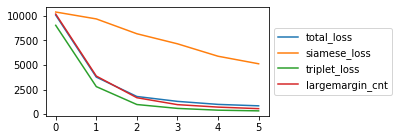

/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.009525740146636963m
I am calculating auc!
K-nn acc. on test dataset is [0.62612613 0.64864865 0.65765766 0.65765766 0.67117117 0.67117117
 0.66666667 0.67117117 0.65315315 0.65315315]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.007207163174947103m
I am calculating auc!
K-nn acc. on test dataset is [0.62162162 0.64864865 0.65765766 0.65315315 0.67117117 0.67117117
 0.67117117 0.66216216 0.64864865 0.65765766]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.007120343049367269m
I am calculating auc!
K-nn acc. on test dataset is [0.61261261 0.64414414 0.64864865 0.65315315 0.66216216 0.65765766
 0.66216216 0.66216216 0.66216216 0.65765766]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.0055118918418884276m
I am calculating auc!
K-nn acc. on test dataset is [0.64414414 0.65315315 0.66216216 0.64864865 0.66666667 0.66666667
 0.66666667 0.67117117 0.66666667 0.66216216]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.005718898773193359m
I am calculating auc!
K-nn acc. on test dataset is [0.61261261 0.63963964 0.65765766 0.66216216 0.67117117 0.67117117
 0.67117117 0.66666667 0.66666667 0.66216216]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.005497237046559651m
I am calculating auc!
K-nn acc. on test dataset is [0.62612613 0.64414414 0.65765766 0.65765766 0.66216216 0.67117117
 0.67117117 0.66666667 0.66666667 0.66216216]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.0055762608846028645m
I am calculating auc!
K-nn acc. on test dataset is [0.61261261 0.64414414 0.65765766 0.65765766 0.66666667 0.66666667
 0.67117117 0.67117117 0.67117117 0.66666667]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.005655344327290853m
I am calculating auc!
K-nn acc. on test dataset is [0.61711712 0.64864865 0.66216216 0.65765766 0.66666667 0.67567568
 0.67117117 0.67117117 0.66216216 0.66666667]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.007750511169433594m
I am calculating auc!
K-nn acc. on test dataset is [0.63513514 0.63963964 0.66666667 0.65765766 0.67117117 0.66216216
 0.66216216 0.66216216 0.67117117 0.66666667]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.007185097535451253m
I am calculating auc!
K-nn acc. on test dataset is [0.63063063 0.63963964 0.66666667 0.65765766 0.67117117 0.67117117
 0.67117117 0.67117117 0.66666667 0.67567568]
Best test accuracy: [0.64414414 0.65315315 0.66666667 0.66216216 0.67117117 0.67567568
 0.67117117 0.67117117 0.67117117 0.67567568]
Best test accuracy index: [3 3 8 4 0 7 1 0 6 9]
Calculating distance matrices...


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


build the model...
... reset target neighbors and imposters
... compute pairwise EDISTNewISkde_C_49_60_5 distance for 664 time series
0.........100.........200.........300.........400.........500.........600......EDISTNewISkde_C_49_60_5 ran for 4.9120110710461935m
train the model...
0th iteration begins...
0.........10000.........
loss for 0th iteration is 9874.462071808957, 10527.11224698741, 8821.750833928585
elapsed time from start is 8.448764832814534m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 664 refs for 0.005540966987609863m
I am calculating auc!
K-nn acc. on valid dataset is [0.68468468 0.67117117 0.68018018 0.68018018 0.66666667 0.66666667
 0.66666667 0.66216216 0.66216216 0.67117117]
update 10 checkpoint at 0th epoch.
1th iteration begins...
0.........10000.........
loss for 1th iteration is 3549.115471330704, 10337.003696987871, 2515.415085732937
elapsed time from start is 19.28349281946818m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 664 refs for 0.006657306353251139m
I am calculating auc!
K-nn acc. on valid dataset is [0.68918919 0.68468468 0.68918919 0.68018018 0.68018018 0.68018018
 0.68468468 0.68018018 0.68018018 0.68018018]
update 9 checkpoint at 1th epoch.
2th iteration begins...
0.........10000.........
loss for 2th iteration is 2031.389570533247, 8535.000557766994, 1177.8895017504692
elapsed time from start is 29.99202135403951m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 664 refs for 0.005110681056976318m
I am calculating auc!
K-nn acc. on valid dataset is [0.6981982  0.69369369 0.69369369 0.6981982  0.68918919 0.68918919
 0.68918919 0.68918919 0.68468468 0.68918919]
update 10 checkpoint at 2th epoch.
3th iteration begins...
0.........10000.........
loss for 3th iteration is 1454.855033390886, 7501.959075877792, 704.6591138243675
elapsed time from start is 44.25909703175227m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 664 refs for 0.005740447839101156m
I am calculating auc!
K-nn acc. on valid dataset is [0.66666667 0.66216216 0.66216216 0.66216216 0.66216216 0.66216216
 0.66666667 0.66666667 0.66216216 0.66216216]
update 0 checkpoint at 3th epoch.
4th iteration begins...
0.........10000.........
loss for 4th iteration is 1080.856898905302, 6344.542627828756, 446.4026268720627
elapsed time from start is 59.64429381291072m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 664 refs for 0.010690867900848389m
I am calculating auc!
K-nn acc. on valid dataset is [0.67567568 0.68018018 0.67117117 0.67567568 0.66666667 0.66666667
 0.66666667 0.66666667 0.66216216 0.66216216]
update 0 checkpoint at 4th epoch.
5th iteration begins...
0.........10000.........
loss for 5th iteration is 954.1402404366318, 5939.252220328519, 360.2150090932846
elapsed time from start is 74.31002839803696m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 664 refs for 0.005614344278971354m
I am calculating auc!
K-nn acc. on valid dataset is [0.68018018 0.67567568 0.67567568 0.67567568 0.67567568 0.67567568
 0.67567568 0.67567568 0.67567568 0.67567568]
update 0 checkpoint at 5th epoch.
Early stopping at 5th iter
Optimization complete.


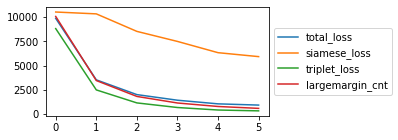

/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.007246180375417074m
I am calculating auc!
K-nn acc. on test dataset is [0.63963964 0.68018018 0.66666667 0.65765766 0.66666667 0.66666667
 0.66216216 0.67117117 0.66666667 0.66216216]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.007209789752960205m
I am calculating auc!
K-nn acc. on test dataset is [0.66216216 0.65765766 0.66216216 0.65765766 0.65765766 0.65765766
 0.66216216 0.66216216 0.67117117 0.66666667]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.008001220226287842m
I am calculating auc!
K-nn acc. on test dataset is [0.65765766 0.66216216 0.66666667 0.66666667 0.65765766 0.65315315
 0.66666667 0.66216216 0.66216216 0.66666667]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.005511720975240071m
I am calculating auc!
K-nn acc. on test dataset is [0.63963964 0.65765766 0.65765766 0.66666667 0.65765766 0.65765766
 0.66216216 0.66216216 0.66666667 0.66216216]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.005440572897593181m
I am calculating auc!
K-nn acc. on test dataset is [0.66666667 0.67117117 0.66216216 0.66666667 0.65765766 0.65315315
 0.66216216 0.66216216 0.66666667 0.66666667]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.007891404628753661m
I am calculating auc!
K-nn acc. on test dataset is [0.66666667 0.66666667 0.65765766 0.65315315 0.66216216 0.65765766
 0.66666667 0.66216216 0.66216216 0.65765766]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.008067882061004639m
I am calculating auc!
K-nn acc. on test dataset is [0.65315315 0.65765766 0.67117117 0.65765766 0.65765766 0.65765766
 0.66216216 0.66666667 0.66666667 0.66666667]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.007198699315388997m
I am calculating auc!
K-nn acc. on test dataset is [0.64414414 0.64864865 0.66216216 0.66216216 0.65315315 0.65765766
 0.65765766 0.66216216 0.66216216 0.67117117]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.00720753272374471m
I am calculating auc!
K-nn acc. on test dataset is [0.66666667 0.67117117 0.65315315 0.65315315 0.65765766 0.66216216
 0.66216216 0.66666667 0.66666667 0.66666667]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.005915021896362305m
I am calculating auc!
K-nn acc. on test dataset is [0.64414414 0.66666667 0.66216216 0.65765766 0.66216216 0.66666667
 0.65765766 0.66216216 0.66666667 0.66666667]
Best test accuracy: [0.66666667 0.68018018 0.67117117 0.66666667 0.66666667 0.66666667
 0.66666667 0.67117117 0.67117117 0.67117117]
Best test accuracy index: [4 0 6 2 0 0 2 0 1 7]
Calculating distance matrices...


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


build the model...
... reset target neighbors and imposters
... compute pairwise EDISTNewISkde_C_49_60_5 distance for 665 time series
0.........100.........200.........300.........400.........500.........600......EDISTNewISkde_C_49_60_5 ran for 7.162320800622305m
train the model...
0th iteration begins...
0.........10000.........
loss for 0th iteration is 9540.878039443272, 9551.45025680834, 8585.733007490635
elapsed time from start is 7.198174611727397m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 665 refs for 0.007846562067667644m
I am calculating auc!
K-nn acc. on valid dataset is [0.68778281 0.69230769 0.69230769 0.68778281 0.69230769 0.69230769
 0.68778281 0.69230769 0.69230769 0.68778281]
update 10 checkpoint at 0th epoch.
1th iteration begins...
0.........10000.........
loss for 1th iteration is 3246.965480068, 9156.29528247565, 2331.335940659046
elapsed time from start is 19.57961006561915m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 665 refs for 0.00860053300857544m
I am calculating auc!
K-nn acc. on valid dataset is [0.70588235 0.69683258 0.71040724 0.70135747 0.70135747 0.70588235
 0.71040724 0.71040724 0.71040724 0.70588235]
update 10 checkpoint at 1th epoch.
2th iteration begins...
0.........10000.........
loss for 2th iteration is 1880.8841269665281, 7501.874442747328, 1130.6966708302498
elapsed time from start is 29.791754682858784m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 665 refs for 0.005776604016621907m
I am calculating auc!
K-nn acc. on valid dataset is [0.66968326 0.67873303 0.67873303 0.67873303 0.67873303 0.66968326
 0.67420814 0.67873303 0.68325792 0.67873303]
update 0 checkpoint at 2th epoch.
3th iteration begins...
0.........10000.........
loss for 3th iteration is 1261.1257769687654, 6322.69772234722, 628.8559945225716
elapsed time from start is 40.23947139978409m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 665 refs for 0.006335763136545817m
I am calculating auc!
K-nn acc. on valid dataset is [0.68325792 0.67873303 0.67873303 0.67420814 0.67420814 0.66968326
 0.66968326 0.66968326 0.66968326 0.66968326]
update 0 checkpoint at 3th epoch.
4th iteration begins...
0.........10000.........
loss for 4th iteration is 970.0168687777768, 5405.315222165198, 429.4853373169899
elapsed time from start is 49.70739679733912m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 665 refs for 0.005976740519205729m
I am calculating auc!
K-nn acc. on valid dataset is [0.66063348 0.66515837 0.66063348 0.66515837 0.66515837 0.66515837
 0.66968326 0.66968326 0.66515837 0.66968326]
update 0 checkpoint at 4th epoch.
5th iteration begins...
0.........10000.........
loss for 5th iteration is 704.9314228228855, 4227.464973215399, 282.18491864204407
elapsed time from start is 60.42057710488637m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 665 refs for 0.005692621072133382m
I am calculating auc!
K-nn acc. on valid dataset is [0.67873303 0.67873303 0.67873303 0.68325792 0.68778281 0.68778281
 0.68778281 0.68778281 0.69230769 0.70588235]
update 0 checkpoint at 5th epoch.
Early stopping at 5th iter
Optimization complete.


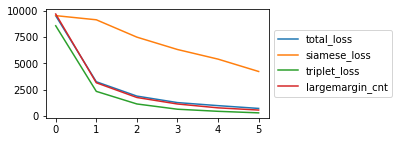

/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.005473438898722331m
I am calculating auc!
K-nn acc. on test dataset is [0.65315315 0.66216216 0.69369369 0.71171171 0.72072072 0.72072072
 0.71171171 0.71171171 0.71171171 0.7027027 ]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.005443469683329264m
I am calculating auc!
K-nn acc. on test dataset is [0.66216216 0.68918919 0.69369369 0.71621622 0.72072072 0.71171171
 0.70720721 0.70720721 0.71171171 0.71171171]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.005517144997914632m
I am calculating auc!
K-nn acc. on test dataset is [0.68018018 0.69369369 0.69369369 0.70720721 0.71621622 0.71621622
 0.71171171 0.72522523 0.7027027  0.6981982 ]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.0055242260297139485m
I am calculating auc!
K-nn acc. on test dataset is [0.68018018 0.70720721 0.70720721 0.70720721 0.70720721 0.70720721
 0.71621622 0.71171171 0.71171171 0.70720721]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.005555287996927897m
I am calculating auc!
K-nn acc. on test dataset is [0.68468468 0.69369369 0.6981982  0.6981982  0.71171171 0.70720721
 0.70720721 0.70720721 0.70720721 0.7027027 ]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.005540120601654053m
I am calculating auc!
K-nn acc. on test dataset is [0.68468468 0.68918919 0.68468468 0.70720721 0.70720721 0.71621622
 0.71621622 0.71621622 0.72072072 0.71171171]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.005563696225484212m
I am calculating auc!
K-nn acc. on test dataset is [0.65765766 0.7027027  0.7027027  0.71171171 0.71171171 0.71621622
 0.71621622 0.71621622 0.71171171 0.71171171]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.005886884530385336m
I am calculating auc!
K-nn acc. on test dataset is [0.65765766 0.66666667 0.68018018 0.71171171 0.71171171 0.72072072
 0.71171171 0.70720721 0.70720721 0.70720721]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.005596371491750082m
I am calculating auc!
K-nn acc. on test dataset is [0.68918919 0.68018018 0.7027027  0.71621622 0.70720721 0.71171171
 0.71621622 0.71621622 0.72072072 0.71621622]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 886 refs for 0.005461768309275309m
I am calculating auc!
K-nn acc. on test dataset is [0.67117117 0.67567568 0.68468468 0.70720721 0.70720721 0.71171171
 0.71621622 0.71171171 0.72072072 0.71171171]
Best test accuracy: [0.68918919 0.70720721 0.70720721 0.71621622 0.72072072 0.72072072
 0.71621622 0.72522523 0.72072072 0.71621622]
Best test accuracy index: [8 3 3 1 0 0 3 2 5 8]
Calculating distance matrices...


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


build the model...
... reset target neighbors and imposters
... compute pairwise EDISTNewISkde_C_49_60_5 distance for 666 time series
0.........100.........200.........300.........400.........500.........600......EDISTNewISkde_C_49_60_5 ran for 4.7526282151540125m
train the model...
0th iteration begins...
0.........10000.........
loss for 0th iteration is 9167.590740748565, 10147.77466401062, 8152.813265860081
elapsed time from start is 6.591224340597789m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 666 refs for 0.006256747245788574m
I am calculating auc!
K-nn acc. on valid dataset is [0.62443439 0.62895928 0.62443439 0.63348416 0.63348416 0.63800905
 0.63800905 0.63348416 0.63348416 0.6199095 ]
update 10 checkpoint at 0th epoch.
1th iteration begins...
0.........10000.........
loss for 1th iteration is 2959.547163862735, 9810.824176687747, 1978.4647322893143
elapsed time from start is 16.995922935009002m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 666 refs for 0.005080529054005941m
I am calculating auc!
K-nn acc. on valid dataset is [0.57918552 0.57013575 0.57013575 0.56561086 0.56108597 0.56561086
 0.57013575 0.57013575 0.57013575 0.57013575]
update 0 checkpoint at 1th epoch.
2th iteration begins...
0.........10000.........
loss for 2th iteration is 1636.8182998739649, 7714.07834767364, 865.4104533195496
elapsed time from start is 26.07570517460505m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 666 refs for 0.006223944822947184m
I am calculating auc!
K-nn acc. on valid dataset is [0.59728507 0.59276018 0.59276018 0.59276018 0.58823529 0.58823529
 0.58371041 0.58371041 0.58371041 0.57918552]
update 0 checkpoint at 2th epoch.
3th iteration begins...
0.........10000.........
loss for 3th iteration is 1081.3968281985144, 6161.723261655308, 465.22449254989624
elapsed time from start is 35.97671007315318m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 666 refs for 0.005886658032735189m
I am calculating auc!
K-nn acc. on valid dataset is [0.62443439 0.61085973 0.61538462 0.6199095  0.6199095  0.62443439
 0.62895928 0.62895928 0.63348416 0.62895928]
update 1 checkpoint at 3th epoch.
4th iteration begins...
0.........10000.........
loss for 4th iteration is 828.1713871991378, 5154.552544939099, 312.7161241173744
elapsed time from start is 45.00741856892903m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 666 refs for 0.0051988045374552405m
I am calculating auc!
K-nn acc. on valid dataset is [0.61085973 0.61085973 0.61085973 0.60180995 0.60180995 0.60633484
 0.60633484 0.60180995 0.60180995 0.60633484]
update 0 checkpoint at 4th epoch.
5th iteration begins...
0.........10000.........
loss for 5th iteration is 679.3144630573079, 4394.479566857743, 239.86649948358536
elapsed time from start is 54.913461383183794m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 666 refs for 0.0057999610900878905m
I am calculating auc!
K-nn acc. on valid dataset is [0.56561086 0.56561086 0.56561086 0.56108597 0.56108597 0.56108597
 0.56108597 0.56108597 0.56108597 0.56108597]
update 0 checkpoint at 5th epoch.
Early stopping at 5th iter
Optimization complete.


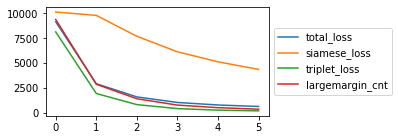

/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 887 refs for 0.00521626869837443m
I am calculating auc!
K-nn acc. on test dataset is [0.57466063 0.58371041 0.59728507 0.61538462 0.58823529 0.58823529
 0.59276018 0.59728507 0.59728507 0.60180995]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 887 refs for 0.005240817864735921m
I am calculating auc!
K-nn acc. on test dataset is [0.57466063 0.56561086 0.59728507 0.60633484 0.59728507 0.61538462
 0.60180995 0.60180995 0.60633484 0.60633484]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 887 refs for 0.005139978726704916m
I am calculating auc!
K-nn acc. on test dataset is [0.55656109 0.57013575 0.57918552 0.59728507 0.59276018 0.59276018
 0.58823529 0.59728507 0.60180995 0.60633484]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 887 refs for 0.005181380112965902m
I am calculating auc!
K-nn acc. on test dataset is [0.57466063 0.59728507 0.61085973 0.6199095  0.59276018 0.59728507
 0.60180995 0.60180995 0.61085973 0.60633484]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 887 refs for 0.005202468236287435m
I am calculating auc!
K-nn acc. on test dataset is [0.58371041 0.58823529 0.60180995 0.61085973 0.59728507 0.59728507
 0.59276018 0.59276018 0.60180995 0.60180995]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 887 refs for 0.005228765805562337m
I am calculating auc!
K-nn acc. on test dataset is [0.57466063 0.58823529 0.61085973 0.60633484 0.60180995 0.59276018
 0.60180995 0.59728507 0.59276018 0.59276018]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 887 refs for 0.005248872439066569m
I am calculating auc!
K-nn acc. on test dataset is [0.58823529 0.58371041 0.57918552 0.61085973 0.58823529 0.58371041
 0.58823529 0.59728507 0.60180995 0.60180995]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 887 refs for 0.005371753374735514m
I am calculating auc!
K-nn acc. on test dataset is [0.57013575 0.57918552 0.59276018 0.61538462 0.59728507 0.59276018
 0.59728507 0.59728507 0.60180995 0.60180995]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 887 refs for 0.005659413337707519m
I am calculating auc!
K-nn acc. on test dataset is [0.56561086 0.57013575 0.58371041 0.60633484 0.58823529 0.59728507
 0.59276018 0.59276018 0.61085973 0.61085973]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 887 refs for 0.0055575728416442875m
I am calculating auc!
K-nn acc. on test dataset is [0.57918552 0.58371041 0.60180995 0.59276018 0.60180995 0.58823529
 0.59276018 0.59276018 0.59728507 0.60180995]
Best test accuracy: [0.58823529 0.59728507 0.61085973 0.6199095  0.60180995 0.61538462
 0.60180995 0.60180995 0.61085973 0.61085973]
Best test accuracy index: [6 3 3 3 5 1 1 1 3 8]
Calculating distance matrices...


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


build the model...
... reset target neighbors and imposters
... compute pairwise EDISTNewISkde_C_49_60_5 distance for 665 time series
0.........100.........200.........300.........400.........500.........600......EDISTNewISkde_C_49_60_5 ran for 4.667214798927307m
train the model...
0th iteration begins...
0.........10000.........
loss for 0th iteration is 9562.43681751631, 10444.908018636575, 8517.946008086205
elapsed time from start is 6.025048228104909m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 665 refs for 0.00614697535832723m
I am calculating auc!
K-nn acc. on valid dataset is [0.64864865 0.63963964 0.66666667 0.65765766 0.66216216 0.65315315
 0.65765766 0.65765766 0.65765766 0.64864865]
update 10 checkpoint at 0th epoch.
1th iteration begins...
0.........10000.........
loss for 1th iteration is 3233.436118045822, 9018.080212257337, 2331.6280831694603
elapsed time from start is 15.52235988775889m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 665 refs for 0.006409013271331787m
I am calculating auc!
K-nn acc. on valid dataset is [0.65765766 0.66216216 0.66216216 0.67117117 0.67117117 0.66666667
 0.66666667 0.66216216 0.66666667 0.67117117]
update 9 checkpoint at 1th epoch.
2th iteration begins...
0.........10000.........
loss for 2th iteration is 1587.218828419922, 6761.778114619956, 911.0410066843033
elapsed time from start is 25.379386909802754m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 665 refs for 0.005372885862986247m
I am calculating auc!
K-nn acc. on valid dataset is [0.68468468 0.69369369 0.68018018 0.68918919 0.68918919 0.69369369
 0.69369369 0.68918919 0.68468468 0.68468468]
update 10 checkpoint at 2th epoch.
3th iteration begins...
0.........10000.........
loss for 3th iteration is 1149.3986598279007, 5842.5283895227185, 565.1458124518394
elapsed time from start is 34.37841274340948m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 665 refs for 0.006156198183695475m
I am calculating auc!
K-nn acc. on valid dataset is [0.65315315 0.65765766 0.65315315 0.65765766 0.65765766 0.65765766
 0.65765766 0.65765766 0.65315315 0.65315315]
update 0 checkpoint at 3th epoch.
4th iteration begins...
0.........10000.........
loss for 4th iteration is 951.4003341157368, 5234.71273490529, 427.9290514588356
elapsed time from start is 43.9207355817159m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 665 refs for 0.006068277359008789m
I am calculating auc!
K-nn acc. on valid dataset is [0.66666667 0.66666667 0.67117117 0.66216216 0.65765766 0.65765766
 0.65765766 0.65765766 0.65765766 0.65765766]
update 0 checkpoint at 4th epoch.
5th iteration begins...
0.........10000.........
loss for 5th iteration is 880.3235076959027, 4947.237940770465, 385.59970474243164
elapsed time from start is 52.986300484339395m


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 222 data with 665 refs for 0.005807173252105713m
I am calculating auc!
K-nn acc. on valid dataset is [0.65315315 0.66216216 0.64864865 0.65765766 0.65765766 0.65765766
 0.65765766 0.66216216 0.66216216 0.66216216]
update 0 checkpoint at 5th epoch.
Early stopping at 5th iter
Optimization complete.


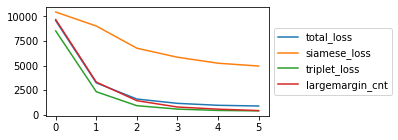

/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 887 refs for 0.005200672149658203m
I am calculating auc!
K-nn acc. on test dataset is [0.66515837 0.66515837 0.66063348 0.63348416 0.63800905 0.64253394
 0.6561086  0.66515837 0.66515837 0.6561086 ]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 887 refs for 0.005374705791473389m
I am calculating auc!
K-nn acc. on test dataset is [0.64705882 0.6561086  0.65158371 0.63348416 0.64253394 0.65158371
 0.6561086  0.63800905 0.65158371 0.64705882]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 887 refs for 0.005294771989186605m
I am calculating auc!
K-nn acc. on test dataset is [0.61538462 0.66968326 0.66968326 0.65158371 0.65158371 0.63348416
 0.64253394 0.66063348 0.66063348 0.66063348]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 887 refs for 0.00544126033782959m
I am calculating auc!
K-nn acc. on test dataset is [0.6199095  0.66063348 0.65158371 0.65158371 0.64705882 0.64253394
 0.64705882 0.6561086  0.6561086  0.65158371]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 887 refs for 0.005440183480580648m
I am calculating auc!
K-nn acc. on test dataset is [0.65158371 0.66968326 0.65158371 0.64705882 0.64705882 0.63348416
 0.65158371 0.64705882 0.66063348 0.66515837]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 887 refs for 0.005198562145233154m
I am calculating auc!
K-nn acc. on test dataset is [0.62895928 0.66063348 0.6561086  0.63348416 0.63800905 0.63800905
 0.6561086  0.65158371 0.65158371 0.65158371]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 887 refs for 0.005190277099609375m
I am calculating auc!
K-nn acc. on test dataset is [0.62895928 0.66063348 0.6561086  0.65158371 0.64253394 0.63348416
 0.64705882 0.64253394 0.64253394 0.65158371]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 887 refs for 0.00531612237294515m
I am calculating auc!
K-nn acc. on test dataset is [0.60633484 0.64705882 0.63348416 0.63800905 0.63800905 0.63800905
 0.63800905 0.65158371 0.6561086  0.65158371]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 887 refs for 0.005268573760986328m
I am calculating auc!
K-nn acc. on test dataset is [0.6199095  0.64705882 0.66063348 0.64253394 0.65158371 0.64253394
 0.64705882 0.65158371 0.64705882 0.66063348]


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 221 data with 887 refs for 0.005232810974121094m
I am calculating auc!
K-nn acc. on test dataset is [0.64705882 0.65158371 0.65158371 0.63800905 0.63348416 0.64253394
 0.64253394 0.66063348 0.6561086  0.6561086 ]
Best test accuracy: [0.66515837 0.66968326 0.66968326 0.65158371 0.65158371 0.65158371
 0.6561086  0.66515837 0.66515837 0.66515837]
Best test accuracy index: [0 2 2 2 2 1 0 0 0 4]
Calculating distance matrices...


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Test accuracy (mean): [0.65067873 0.66150177 0.66511761 0.66330765 0.66239044 0.66600628
 0.66239452 0.66690718 0.66781623 0.66781623]
Test accuracy (std): [0.03432263 0.03660134 0.03090418 0.03108942 0.03816959 0.03422913
 0.03661163 0.0391869  0.03484969 0.03366509]


In [7]:
from sklearn import manifold  # multidimensional scaling

    
## main
if __name__ == '__main__':
    print('starting time: ', datetime.datetime.now())
    # set paths, etc.
    
    arg_parser = argparse.ArgumentParser()
    arg_parser.add_argument('-f', type=str, help='just a placeholder for jupyter notebook args -f. Not used.')
    arg_parser.add_argument('--data_folder', type=str, default=r'../new_data')
    #arg_parser.add_argument('--data_filename', type=str, default=r'ucieeg-down-binary')
    #arg_parser.add_argument('--data_filename', type=str, default=r'ucieeg-new') # (3,10,1, 2)
    #arg_parser.add_argument('--data_filename', type=str, default=r'ucr-data-aspreg')
    #arg_parser.add_argument('--data_filename', type=str, default=r'ras-data-cdnd')
    arg_parser.add_argument('--data_filename', type=str, default=r'physio-data')
    #arg_parser.add_argument('--data_filename', type=str, default=r'syn-data-100-20')
    
    #Physio-net
    arg_parser.add_argument('--distance_type', type=str, default=r'EDISTkdeIS_C_49_60_5')
    #arg_parser.add_argument('--distance_type', type=str, default=r'EDISTisNew_C_49_60_5')
    #arg_parser.add_argument('--distance_type', type=str, default=r'EDISTNew_C_49_60_5')
    #arg_parser.add_argument('--distance_type', type=str, default=r'DTW_C') #
    #arg_parser.add_argument('--distance_type', type=str, default=r'ManhattanLSTM') 
    #arg_parser.add_argument('--distance_type', type=str, default=r'soft-dtw')
    
    #RAS
    #arg_parser.add_argument('--distance_type', type=str, default=r'EDISTisNew_C_5_400_10')
    #60_90 10 70, 60_90_10 5 71, 60_100_10 70 auc 1 60 200 5
    
    # EEG
    #arg_parser.add_argument('--distance_type', type=str, default=r'DTW_C') #
    #arg_parser.add_argument('--distance_type', type=str, default=r'EDISTkdeIS_C_32_48_10')
    #arg_parser.add_argument('--distance_type', type=str, default=r'EDISTNew_C_32_48_10')
    #arg_parser.add_argument('--distance_type', type=str, default=r'EDISTisNew_C_32_48_10') #
    #arg_parser.add_argument('--distance_type', type=str, default=r'Manhattan') 
    
    #ASPREG
    #arg_parser.add_argument('--distance_type', type=str, default=r'DTW_C') #
    #arg_parser.add_argument('--distance_type', type=str, default=r'EDISTisNew_C_350_400_5')
    #arg_parser.add_argument('--distance_type', type=str, default=r'Manhattan')  
    
    #Syn-data
    #arg_parser.add_argument('--distance_type', type=str, default=r'DTW_C') #
    #arg_parser.add_argument('--distance_type', type=str, default=r'EDISTisNew_C_185_240_5')
    #arg_parser.add_argument('--distance_type', type=str, default=r'EDISTisNew_C_90_100_5')
    #arg_parser.add_argument('--distance_type', type=str, default=r'EDISTkdeIS_C_90_100_5')
    #arg_parser.add_argument('--distance_type', type=str, default=r'soft-dtw')
    #arg_parser.add_argument('--distance_type', type=str, default=r'Manhattan')
    
    arg_parser.add_argument('--activations', type=str, default=r'relu,sigmoid')
    #arg_parser.add_argument('--activations', type=str, default=r'')
    arg_parser.add_argument('--hid_dim', type=float, default=1)
    args = arg_parser.parse_args()
    print(args)
    
    data_folder = args.data_folder
    data_filename = args.data_filename
    distance_type = args.distance_type
    activations = args.activations.split(',') 
    hid_dim = args.hid_dim
    
    
            
    distTrTr = []
    distTeTr = []
    
    data_handler = DataHandler(dataset=data_filename, data_folder=data_folder)
    x_folds_tensor, x_folds_nparray, y_folds = data_handler.load_rawdata()
    distance_handler = get_distance_handler(distance_type)
    n_out = 0
    test_accs_all = []
    #for fold_id in range(0,1):
    for fold_id in range(data_handler.nfolds):
        datasets = (x_folds_tensor[fold_id], x_folds_nparray[fold_id], y_folds[fold_id])
        # train model
        learner = TimeseriesMetricLearner(datasets, distance_handler)
        learner.verbose = True
        # set learner parameters
        learner.n_targets = 3
        learner.n_imposters = 10
        learner.delta_ratio = 1
        learner.lambda_ratio = 2.
       
        #learner.set_init_para_lambda()	# control the ratio of target and imposter in objective.
        learner.build_model(data_handler.p, n_hiddens=n_out, activations=activations)
        # steps prepare for training
        learner.reset_targets_and_imposters()
        losses = learner.train(20, reset_ti=False, verbose=1)
        # plot and evaluate
        plt.figure(figsize=(4, 2))
        plot_lines = []
        plot_legends = losses.keys()
        for lk in plot_legends:
            line, = plt.plot(np.arange(len(losses[lk])), losses[lk])
            plot_lines.append(line)
        plt.legend(plot_lines, plot_legends, loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()
        test_acc, _ = learner.evaluate_every_setting()
        test_accs_all.append(test_acc)

        print('Calculating distance matrices...')
        y_ref = np.concatenate((learner.train_set_y, learner.valid_set_y))
        x_ref = [learner.network(Variable(t, volatile=True)).data.numpy() for t in learner.train_set_x_tensor + learner.valid_set_x_tensor]

        dist_tr_tr = np.empty([learner.n_train + learner.n_valid, learner.n_train + learner.n_valid], dtype = float);
        for i in range(len(y_ref)):
            for j in range(len(y_ref)):
                X1 = x_ref[i]
                X2 = x_ref[j]
        
                dist_tr_tr[i][j] = learner.distance_handler.dist(X1, X2)
        
        distTrTr.append(dist_tr_tr)



        dist_te_tr = np.empty([learner.n_test, learner.n_train+learner.n_valid], dtype=object)
        for i_te in range(learner.n_test):
            for i_tr in range(learner.n_train+learner.n_valid):
            
                X1 =learner.network.forward(torch.from_numpy(learner.test_set_x_nparray[i_te])).detach().numpy() 
                X2 = x_ref[i_tr]
        
                dist_te_tr[i_te][i_tr] = learner.distance_handler.dist(X1, X2)
        
        distTeTr.append(dist_te_tr)

        
    print('Test accuracy (mean): {}\nTest accuracy (std): {}'.format(
            np.mean(test_accs_all, axis=0), np.std(test_accs_all, axis=0)))
        

       

In [8]:
#decade is 5 
#print(np.mean(test_accs_all,0))
#print(np.std(test_accs_all,0))
#learner.distance_handler.compute_dist_mtx(
#[learner.network(Variable(t, volatile=True)).data.numpy() for t in learner.train_set_x_tensor]
learner.network(learner.train_set_x_tensor[1]).shape
#learner.train_set_x_tensor[1].shape
#decade 10
#Test accuracy (mean): [0.67411846 0.67141168 0.66689087 0.66779585 0.66509315 0.66058049
# 0.66329135 0.66599812 0.6651013  0.6651013 ]
#Test accuracy (std): [0.03341196 0.0348336  0.03889882 0.03772493 0.03427417 0.03510212
# 0.03612214 0.03627895 0.03453834 0.03547416]

torch.Size([89, 95])

In [8]:
print(np.mean(test_accs_all,0))
print(np.std(test_accs_all,0))

# DTW_C (syn)
# Test accuracy (mean): [0.87333333 0.905      0.92166667 0.925      0.93166667 0.945
#  0.95166667 0.95       0.95833333 0.95166667]
# Test accuracy (std): [0.02321398 0.0214735  0.02392117 0.02527625 0.02758824 0.0335824
#  0.03045944 0.02635231 0.02581989 0.02905933]

# DEcade
#Test accuracy (mean): [0.89833333 0.92666667 0.94166667 0.95       0.955      0.95833333
# 0.95666667 0.96       0.97       0.96666667]
#Test accuracy (std): [0.01433721 0.01615893 0.02108185 0.01900292 0.01943651 0.01581139
# 0.02       0.01615893 0.01545603 0.01394433]

#isea
#Test accuracy (mean): [0.89       0.92166667 0.93       0.94       0.95166667 0.95333333
# 0.95833333 0.96333333 0.95833333 0.96333333]
#Test accuracy (std): [0.0062361  0.01       0.01247219 0.00971825 0.01105542 0.00666667
# 0.01178511 0.01130388 0.01178511 0.01715938]



[0.65337736 0.67143207 0.66781623 0.66963434 0.66962211 0.66690718
 0.66961803 0.67232481 0.67052301 0.67141576]
[0.02949373 0.02443177 0.02797058 0.02278133 0.02779595 0.03197693
 0.02912946 0.03222107 0.0309507  0.03375236]


In [9]:
#decade is 10 
print(np.mean(test_accs_all,0))
print(np.std(test_accs_all,0))

[0.65430272 0.65790632 0.66242713 0.66152216 0.65972035 0.66152623
 0.65701357 0.65881538 0.66062533 0.6570095 ]
[0.01712664 0.02179518 0.01947752 0.02253739 0.02148953 0.02228732
 0.02155729 0.01976169 0.01900185 0.01924139]


In [14]:
#decade is 
Test accuracy (mean): [0.99666667 0.99666667 0.99833333 1.         1.         0.99833333
 0.99833333 1.         0.99833333 0.99833333]
Test accuracy (std): [0.00408248 0.00408248 0.00333333 0.         0.         0.00333333
 0.00333333 0.         0.00333333 0.00333333]



[0.93833333 0.935      0.93833333 0.935      0.935      0.93166667
 0.93333333 0.93       0.93       0.93166667]
[0.00849837 0.01224745 0.01247219 0.01105542 0.01224745 0.01333333
 0.00912871 0.01       0.00666667 0.0062361 ]


In [8]:
from scipy.io import savemat
acc_mean = np.mean(test_accs_all, axis=0)
acc_std =  np.std(test_accs_all, axis=0)
mdic = {"distTrTr": distTrTr, "distTeTr": distTeTr, 'acc_mean': acc_mean, 'acc_std' : acc_std, 'acc': test_accs_all }
#out_dir = '../python_pytorch/results/syn-data-100-15/run_jupyter/'
out_dir = '../python_pytorch/results/NeurIPS2021/physio-data/run_jupyter/'
#out_dir = '../python_pytorch/results/NeurIPS2021/uci-eeg/run_jupyter/'
#out_dir = '../python_pytorch/results/NeurIPS2021/syn-data-100-20/run_jupyter/'
savemat(out_dir + distance_type + '_hid_' +str(hid_dim) + "updated_res.mat", mdic)

In [9]:
# from scipy.io import loadmat
# res = loadmat(out_dir + distance_type + "_res.mat")
distance_type

'EDISTNew_C_49_60_5'

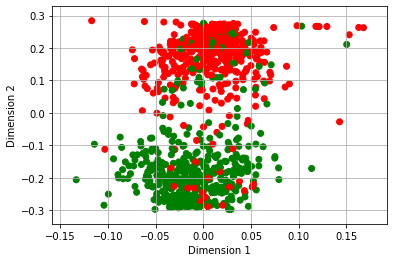

In [9]:
dist_tr_tr = distTrTr[4]
y_ref = np.concatenate((learner.train_set_y, learner.valid_set_y))
dist_mat = dist_tr_tr*0.5 + dist_tr_tr.T*0.5
mds_model = manifold.MDS(n_components = 2, random_state = 123, dissimilarity = 'precomputed')
#mds_model = manifold.TSNE(n_components = 3, random_state = 0,metric = 'precomputed')
#manifold.TSNE(n_components=2, random_state=0, metric='precomputed')
mds_fit = mds_model.fit(dist_mat)  
mds_coords = mds_model.fit_transform(dist_mat) 
color= ['red' if l == 0 else 'green' for l in y_ref]
#color= ['red' if l == 0 else 'green' for l in learner.test_set_y]
plt.figure()
plt.scatter(mds_coords[:,0],mds_coords[:,1], color=color)
plt.grid()
plt.axis('tight')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
#plt.savefig('../python_pytorch/results/NeurIPS2021/syn-data-100-20/run_jupyter/syn-data-100-20-ISEA-KDE-5-embedding.png', bbox_inches='tight')
plt.savefig('../python_pytorch/results/NeurIPS2021/physio-data/run_jupyter/physio-data-ISEA-KDE-updated-embedding.png', bbox_inches='tight')
#plt.savefig('../python_pytorch/results/NeurIPS2021/uci-eeg/run_jupyter/uci-eeg-Manhattan-LSTM-embedding.png', bbox_inches='tight')

plt.show()

In [20]:
x_eval=learner.test_set_x_tensor 
y_eval=learner.test_set_y
x_ref=learner.train_set_x_tensor + learner.valid_set_x_tensor
y_ref=np.concatenate((learner.train_set_y, learner.valid_set_y))

inp_eval = [learner.network(Variable(t, volatile=True)).data.numpy() for t in x_eval]
inp_ref = [learner.network(Variable(t, volatile=True)).data.numpy() for t in x_ref]
test_dataset = (inp_eval, y_eval)
train_dataset = (inp_ref, y_ref)

# extract dataset
test_set_x, test_set_y = test_dataset
train_set_x, train_set_y = train_dataset
n_train = len(train_set_x)
n_test = len(test_set_x)
# compute distance between validation and training
dist_te_tr = np.empty([n_test, n_train], dtype=object)
for i_te, x_te in enumerate(test_set_x):
    for i_tr, x_tr in enumerate(train_set_x):
        dist_te_tr[i_te][i_tr] = learner.distance_handler.dist(x_te, x_tr)

k = 9
sorted_id = np.argsort(dist_te_tr)
y_k = y_ref[sorted_id[:,:k]]
mode_dat = stats.mode(y_k, axis=1)        
y_pred = np.squeeze(mode_dat[0])


/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


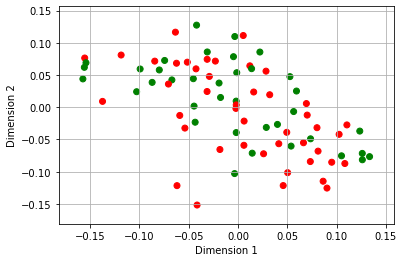

In [14]:
n_test = learner.n_test
y_eval=learner.test_set_y
dist_te_te = np.empty([n_test, n_test], dtype=object)
for i_te in range(learner.n_test):
    for i_tr in range(learner.n_test):
        #X1 = learner.test_set_x_nparray[i_te]
        #X2 = learner.test_set_x_nparray[i_tr]
        
        X1 = learner.network.forward(torch.from_numpy(learner.test_set_x_nparray[i_te])).detach().numpy()
        X2 = learner.network.forward(torch.from_numpy(learner.test_set_x_nparray[i_tr])).detach().numpy()
  
        dist_te_te[i_te][i_tr] = learner.distance_handler.dist(X1, X2)

dist_mat = dist_te_te*0.5 + dist_te_te.T*0.5
mds_model = manifold.MDS(n_components = 2, random_state = 123, dissimilarity = 'precomputed')
#mds_model = manifold.TSNE(n_components = 3, random_state = 0,metric = 'precomputed')
#manifold.TSNE(n_components=2, random_state=0, metric='precomputed')
mds_fit = mds_model.fit(dist_mat)  
mds_coords = mds_model.fit_transform(dist_mat) 
color= ['red' if l == 0 else 'green' for l in y_eval]
plt.figure()
plt.scatter(mds_coords[:,0],mds_coords[:,1], color=color)
plt.grid()
plt.axis('tight')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
#plt.savefig('../python_pytorch/results/ras-entry-angle/isdecade-before-rep-auc.png', bbox_inches='tight')
#plt.savefig('../python_pytorch/results/eeg/MaLSTM__after_test.png', bbox_inches='tight')

plt.show()

In [39]:
# evaluate KNN accuracy
#sorted_id = np.argsort(dist_te_tr)
#y_k = train_set_y[sorted_id[:,:k]]
from sklearn.metrics import balanced_accuracy_score

def knn_auc(dist_matrix, y_true, y_ref, K=range(1,20,2)):
 
    sorted_id = np.argsort(dist_matrix)
    acc = np.zeros([len(dist_matrix), len(K)])
    auc = np.zeros([len(K)])
    bal_acc = np.zeros([len(K)])
    f1 = np.zeros([len(K)])
    for i_k, k in enumerate(K):
        w = 1 + 0.5 * np.power(0.5, range(k))
        y_k = y_ref[sorted_id[:,:k]]
        y_pred = []
        for i in range(len(dist_matrix)):
            acc[i][i_k] = np.argmax(np.bincount(y_k[i], w)) == y_true[i]
            y_pred.append(np.argmax(np.bincount(y_k[i], w)))
        bal_acc[i_k] = balanced_accuracy_score(y_true, y_pred)
        
    
        mode_dat = stats.mode(y_k,axis=1)
      
        f1[i_k] = fbeta_score(y_true,  np.squeeze(mode_dat[0]), beta=1.0)
      

        auc[i_k] = roc_auc_score(y_true, np.mean(y_k,1))
    print('I am calculating aucs!')
    print(y_true.shape)
    print(y_ref.shape)
    print(np.mean(y_k,1).shape)
        
    print('I am calculating aucs!')
    return np.mean(acc, axis=0), bal_acc

# auc
this_knn_auc, this_bal_acc = knn_auc(dist_te_tr, test_set_y, train_set_y)





 #       return self.evaluate_handler.knn_accuracy(dataset_eval, dataset_ref)
        

I am calculating aucs!
(81,)
(325,)
(81,)
I am calculating aucs!


In [41]:
print(this_bal_acc)
print(this_knn_auc)

[0.43427518 0.48402948 0.52027027 0.55159705 0.54944717 0.54944717
 0.54944717 0.54944717 0.54944717 0.54944717]
[0.43209877 0.48148148 0.51851852 0.54320988 0.54320988 0.54320988
 0.54320988 0.54320988 0.54320988 0.54320988]


In [56]:
sorted_id = np.argsort(dist_te_tr)
y_k = train_set_y[sorted_id[:,:20]]
y_k.shape

(160, 20)

In [86]:
from sklearn.metrics import average_precision_score, confusion_matrix, balanced_accuracy_score
k = 4
mode_dat = stats.mode(y_k[:,:k], axis=1)
acc = np.mean(np.squeeze(mode_dat[0]) == y_eval)
f1 = fbeta_score(y_eval,  np.squeeze(mode_dat[0]), beta=1)
auc = roc_auc_score(y_eval, np.mean(y_k[:,:k],1))

c_m = confusion_matrix(y_eval,  np.squeeze(mode_dat[0]))
ba = balanced_accuracy_score(y_eval, np.squeeze(mode_dat[0]))
print(acc, f1, auc, ap, ba)
print(c_m)

0.8 0.2 0.6294424019607843 0.21582602339181284 0.5392156862745098
[[124  12]
 [ 20   4]]


24

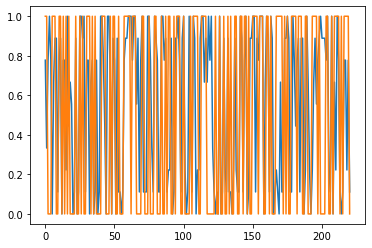

In [13]:
plt.plot(np.mean(y_k[:,:k],1))
plt.plot(y_eval)

In [42]:
mode_dat = stats.mode(y_k,axis=1)
np.squeeze(mode_dat[0]).shape

(160,)

In [47]:

roc_auc_score(y_eval, np.mean(y_k,1))
mode_dat = stats.mode(y_k,axis=1)
f1 = fbeta_score(y_eval,  np.squeeze(mode_dat[0]), beta=1)


0.1904761904761905

In [55]:
this_knn_auc

array([0.8   , 0.8   , 0.7875, 0.7875, 0.7875, 0.7875, 0.7875, 0.7875,
       0.7875, 0.7875])

In [8]:
# something to think of:

# Keep the same targets, but only update imposters (or also keep it. Originally all imposters are considered)
# Change the value of margin
# Think of how the to change the learning rate
# Plot: valid losses, valid/test knn, etc.

In [10]:
from sklearn import manifold  # multidimensional scaling

# visualize learnt representations
dist_tr_tr = np.empty([learner.n_train, learner.n_train], dtype = float);
for i in range(learner.n_train):
        for j in range(learner.n_train):
            #X1 = learner.network.forward(torch.from_numpy(learner.train_set_x_nparray[i])).detach().numpy()
            #X2 = learner.network.forward(torch.from_numpy(learner.train_set_x_nparray[j])).detach().numpy()
            X1 = learner.train_set_x_nparray[i]
            X2 = learner.train_set_x_nparray[j]

            #dist_tr_tr[i][j], _ _ = learner.distance_handler.dist_and_path(X1, X2)
            dist_tr_tr[i][j] = learner.distance_handler.dist(X1, X2)
            #print(Variable(learner.train_set_x_tensor[i][torch.IntTensor(path_i1).long()]).shape)
            #print(Variable(learner.train_set_x_tensor[j][torch.IntTensor(path_j1).long()]).shape)
            #break


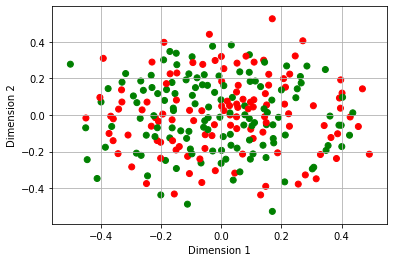

In [11]:
dist_mat = dist_tr_tr*0.5 + dist_tr_tr.T*0.5
mds_model = manifold.MDS(n_components = 2, random_state = 123, dissimilarity = 'precomputed')
#mds_model = manifold.TSNE(n_components = 3, random_state = 0,metric = 'precomputed')
#manifold.TSNE(n_components=2, random_state=0, metric='precomputed')
mds_fit = mds_model.fit(dist_mat)  
mds_coords = mds_model.fit_transform(dist_mat) 
color= ['red' if l == 0 else 'green' for l in learner.train_set_y]
plt.figure()
plt.scatter(mds_coords[:,0],mds_coords[:,1], color=color)
plt.grid()
plt.axis('tight')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
#plt.savefig('../python_pytorch/results/eeg/MaLSTM_32_48_10_3_10_1_2_half_before.png', bbox_inches='tight')
plt.show()

1


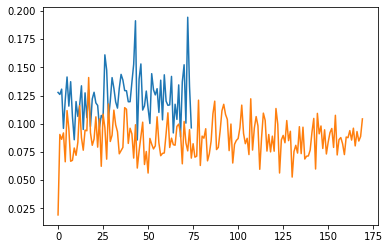

In [11]:
print(learner.train_set_y[0])
plt.plot(dist_tr_tr[0][learner.train_set_y==0])
plt.plot(dist_tr_tr[0][learner.train_set_y==1])
#plt.plot(learner.train_set_y*0.4)

In [70]:
X1 = learner.train_set_x_nparray[0]
X2 = learner.train_set_x_nparray[0]
d, _,_ = learner.distance_handler.dist_and_path(X1, X2)

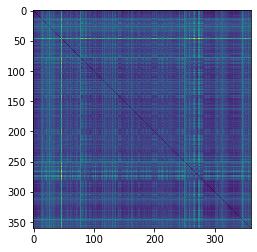

In [71]:
plt.imshow(dist_mat)

AttributeError: module 'matplotlib.pyplot' has no attribute 'zlabel'

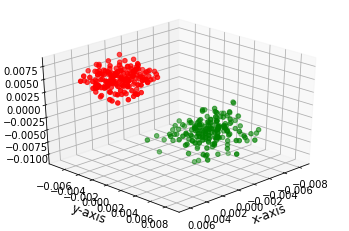

In [139]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mds_coords[:,0],mds_coords[:,1], mds_coords[:,2], color=color)
ax.view_init(30, 45)
plt.xlabel('x-axis', fontsize=12)
plt.ylabel('y-axis', fontsize=12)
plt.zlabel('z-axis', fontsize=14)
plt.show()


In [13]:
X2.shape

(32, 32)

In [23]:
k = 9
i = 1
w = 1 + 0.5 * np.power(0.5, range(k))
y_eval=learner.test_set_y
y_ref=np.concatenate((learner.train_set_y, learner.valid_set_y))
sorted_id = np.argsort(dist_te_tr)
y_k = y_ref[sorted_id[:,:k]]

In [75]:
out_dir = '../python_pytorch/results/ucieeg-new/run_jupyter/'

In [76]:
distance_type

'EDISTisNew_C_32_48_5'

/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


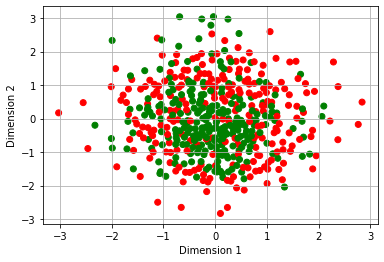

In [81]:
# visualize learnt representations
y_ref = np.concatenate((learner.train_set_y, learner.valid_set_y))
x_ref = [Variable(t, volatile=True).data.numpy() for t in learner.train_set_x_tensor + learner.valid_set_x_tensor]

dist_tr_tr = np.empty([learner.n_train + learner.n_valid, learner.n_train + learner.n_valid], dtype = float);
for i in range(len(y_ref)):
    for j in range(len(y_ref)):
        X1 = x_ref[i]
        X2 = x_ref[j]

            #dist_tr_tr[i][j], _, _ = learner.distance_handler.dist_and_path(X1, X2)
        dist_tr_tr[i][j] = learner.distance_handler.dist(X1, X2)

            
dist_mat = dist_tr_tr*0.5 + dist_tr_tr.T*0.5
mds_model = manifold.MDS(n_components = 2, random_state = 123, dissimilarity = 'precomputed')
#mds_model = manifold.TSNE(n_components = 3, random_state = 0,metric = 'precomputed')
#manifold.TSNE(n_components=2, random_state=0, metric='precomputed')
mds_fit = mds_model.fit(dist_mat)  
mds_coords = mds_model.fit_transform(dist_mat) 
    
color= ['red' if l == 0 else 'green' for l in y_ref]
plt.figure()
plt.scatter(mds_coords[:,0],mds_coords[:,1], color=color)
plt.grid()
plt.axis('tight')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.savefig(out_dir + distance_type + '_before.png', bbox_inches='tight')
    #plt.show()

/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


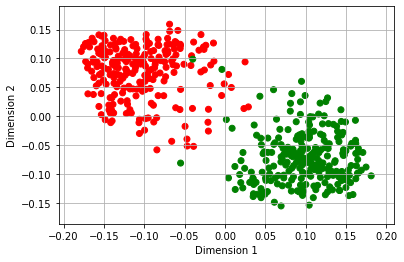

In [82]:
 
y_ref = np.concatenate((learner.train_set_y, learner.valid_set_y))
x_ref = [learner.network(Variable(t, volatile=True)).data.numpy() for t in learner.train_set_x_tensor + learner.valid_set_x_tensor]

dist_tr_tr = np.empty([learner.n_train + learner.n_valid, learner.n_train + learner.n_valid], dtype = float);
for i in range(len(y_ref)):
    for j in range(len(y_ref)):
        X1 = x_ref[i]
        X2 = x_ref[j]
        
        dist_tr_tr[i][j] = learner.distance_handler.dist(X1, X2)

            
dist_mat = dist_tr_tr*0.5 + dist_tr_tr.T*0.5
mds_model = manifold.MDS(n_components = 2, random_state = 123, dissimilarity = 'precomputed')
#mds_model = manifold.TSNE(n_components = 3, random_state = 0,metric = 'precomputed')
#manifold.TSNE(n_components=2, random_state=0, metric='precomputed')
mds_fit = mds_model.fit(dist_mat)  
mds_coords = mds_model.fit_transform(dist_mat) 
    
color= ['red' if l == 0 else 'green' for l in y_ref]
plt.figure()
plt.scatter(mds_coords[:,0],mds_coords[:,1], color=color)
plt.grid()
plt.axis('tight')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.savefig(out_dir + distance_type + '_after.png', bbox_inches='tight')
    #plt.show()

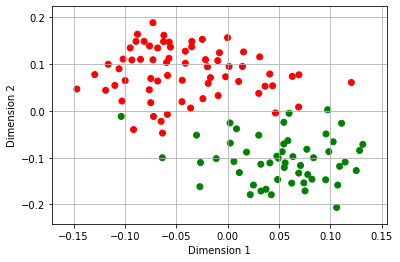

In [83]:
        

n_test = learner.n_test
y_eval=learner.test_set_y
dist_te_te = np.empty([n_test, n_test], dtype=object)
for i_te in range(learner.n_test):
    for i_tr in range(learner.n_test):
            
        X1 =learner.network.forward(torch.from_numpy(learner.test_set_x_nparray[i_te])).detach().numpy() 
        X2 =learner.network.forward(torch.from_numpy(learner.test_set_x_nparray[i_tr])).detach().numpy()
        dist_te_te[i_te][i_tr] = learner.distance_handler.dist(X1, X2)

dist_mat = dist_te_te*0.5 + dist_te_te.T*0.5
mds_model = manifold.MDS(n_components = 2, random_state = 123, dissimilarity = 'precomputed')
#mds_model = manifold.TSNE(n_components = 3, random_state = 0,metric = 'precomputed')
#manifold.TSNE(n_components=2, random_state=0, metric='precomputed')
mds_fit = mds_model.fit(dist_mat)  
mds_coords = mds_model.fit_transform(dist_mat) 
color= ['red' if l == 0 else 'green' for l in y_eval]
plt.figure()
plt.scatter(mds_coords[:,0],mds_coords[:,1], color=color)
plt.grid()
plt.axis('tight')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.savefig(out_dir + distance_type + '_test.png', bbox_inches='tight')
    

In [85]:
y_ref = np.concatenate((learner.train_set_y, learner.valid_set_y))
x_ref = [learner.network(Variable(t, volatile=True)).data.numpy() for t in learner.train_set_x_tensor + learner.valid_set_x_tensor]


dist_te_tr = np.empty([learner.n_test, learner.n_train+learner.n_valid], dtype=object)
for i_te in range(learner.n_test):
    for i_tr in range(learner.n_train+learner.n_valid):
            
        X1 =learner.network.forward(torch.from_numpy(learner.test_set_x_nparray[i_te])).detach().numpy() 
        X2 = x_ref[i_tr]
        #X2 =learner.network.forward(torch.from_numpy(learner.train_set_x_nparray[i_tr])).detach().numpy()
        dist_te_tr[i_te][i_tr] = learner.distance_handler.dist(X1, X2)

            
    
acc_mean = np.mean(test_accs_all, axis=0)
acc_std =  np.std(test_accs_all, axis=0)
    #save(dist_tr_tr, dist_te_tr, dist_te_te, acc_mean, acc_std)
    
mdic = {"distTrTr": dist_tr_tr, "distTeTr": dist_te_tr, "distTeTe": dist_te_te, 'acc_mean': acc_mean, 'acc_std' : acc_std  }

from scipy.io import savemat
savemat(out_dir + distance_type + "_res.mat", mdic)

/home/sirisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


In [86]:
from scipy.io import savemat
savemat(out_dir + distance_type + "_res.mat", mdic)

In [67]:
datafolder = '../new_data/ucieeg-new/'
datafile = datafolder + 'ucieeg-new.mat'
foldfile = datafolder + 'ucieeg-new-5folds.mat'
fold_id = 4
plot = True

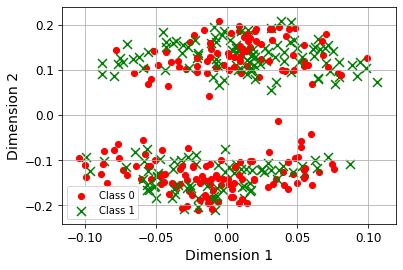

In [72]:
from scipy.io import loadmat
dat = loadmat(datafile)
y = np.squeeze(dat['y'])

fold_f = loadmat(foldfile)
I = fold_f['folds']

    #neig = loadmat(neighbor_file)
    #neig['neighborTrTe']

#trI = np.where(I != fold_id + 1)[1]
#testI = np.where(I == fold_id hg+ 1)[1]

testI = I == fold_id+1
I_valid = I == ((fold_id+1)%5 + 1)
trI = np.logical_not(np.logical_or(testI, I_valid))

y_eval = [y[i] for i in testI]
y_true = [y[i] for i in trI + I_valid][0]

if plot == True:
    dist_mat = dist_tr_tr*0.5 + dist_tr_tr.T*0.5
    # dist_mat = dist_tr_tr
    mds_model = manifold.MDS(n_components = 2, random_state = 123, dissimilarity = 'precomputed')
    #mds_model = manifold.TSNE(n_components = 3, random_state = 0,metric = 'precomputed')
    #manifold.TSNE(n_components=2, random_state=0, metric='precomputed')
    mds_fit = mds_model.fit(dist_mat)  
    mds_coords = mds_model.fit_transform(dist_mat) 
    color= ['red' if l == 0 else 'green' for l in y_true]
    marks = ['.' if l == 0 else "x" for l in y_true]

    
    ax = plt.axes()
    
    for i in range(0,mds_coords.shape[0]):
        if marks[i] == '.':
            cl0 = ax.scatter(mds_coords[i,0],mds_coords[i,1], color=color[i] , marker=marks[i],  s=150)
        else:
            cl1 = ax.scatter(mds_coords[i,0],mds_coords[i,1], color=color[i] , marker=marks[i],  s=80)
      #  plt.scatter(mds_coords[i,0],mds_coords[i,1], color=color[i] , marker=marks[i],  s=20)
    #plt.scatter(mds_coords[:,0],mds_coords[:,1], color=color)
    #ax = plt.axes(projection ="3d")
    #ax.scatter3D(mds_coords[:,0],mds_coords[:,1], mds_coords[:,2], color=color, marker=marker)
    ax.grid()
    ax.axis('tight')
    ax.set_xlabel('Dimension 1', fontsize=14)
    ax.set_ylabel('Dimension 2', fontsize=14) 
    ax.tick_params(axis='both', which='major', labelsize=12,  length=4)
    ax.tick_params(axis='both', which='minor', labelsize=12, length=4)
    ax.legend((cl0, cl1), ['Class 0', 'Class 1'], loc='lower left')
 

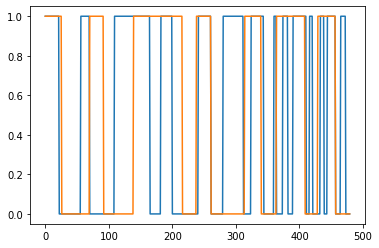

In [73]:
y_ref = np.concatenate((learner.train_set_y, learner.valid_set_y))
plt.plot(y_ref)
plt.plot(y_true)

In [71]:
[2, 3, 5] + [ 1, 4]

[2, 3, 5, 1, 4]

In [47]:
len(trI)


600

In [9]:
from scipy.io import savemat
mdic = {"distTrTr": distTrTr, "distTeTr": distTeTr, 'acc_mean': acc_mean, 'acc_std' : acc_std, 'acc': test_acc_all }
out_dir = '../python_pytorch/results/ucieeg-new/run_jupyter/'

savemat(out_dir + distance_type + "_res.mat", mdic)

5

In [11]:
out_dir = '../python_pytorch/results/ucieeg-new/run_jupyter/'

In [12]:
out_dir

'/home/sirisha/TimeWarping/TimeSeriesMetricLearning/python_pytorch/results/ucieeg-new/run_jupyter/'

In [87]:
l =  []
l.append(dist_tr_tr)
l.append(dist_tr_tr)


In [93]:
savemat(out_dir + 'test.mat', {'distTrTr':l})

In [94]:
res = loadmat(out_dir + 'test.mat')

(2, 480, 480)

In [ ]:
distTrTr = []
distTeTr = []

y_ref = np.concatenate((learner.train_set_y, learner.valid_set_y))
x_ref = [learner.network(Variable(t, volatile=True)).data.numpy() for t in learner.train_set_x_tensor + learner.valid_set_x_tensor]

dist_tr_tr = np.empty([learner.n_train + learner.n_valid, learner.n_train + learner.n_valid], dtype = float);
for i in range(len(y_ref)):
    for j in range(len(y_ref)):
        X1 = x_ref[i]
        X2 = x_ref[j]
        
        dist_tr_tr[i][j] = learner.distance_handler.dist(X1, X2)
        
distTrTr.append(dist_tr_tr)

#y_ref = np.concatenate((learner.train_set_y, learner.valid_set_y))
#x_ref = [learner.network(Variable(t, volatile=True)).data.numpy() for t in learner.train_set_x_tensor + learner.valid_set_x_tensor]



dist_te_tr = np.empty([learner.n_test, learner.n_train+learner.n_valid], dtype=object)
for i_te in range(learner.n_test):
    for i_tr in range(learner.n_train+learner.n_valid):
            
        X1 =learner.network.forward(torch.from_numpy(learner.test_set_x_nparray[i_te])).detach().numpy() 
        X2 = x_ref[i_tr]
        
        dist_te_tr[i_te][i_tr] = learner.distance_handler.dist(X1, X2)
        
distTeTr.append(dist_te_tr)


    
acc_mean = np.mean(test_accs_all, axis=0)
acc_std =  np.std(test_accs_all, axis=0)
    #save(dist_tr_tr, dist_te_tr, dist_te_te, acc_mean, acc_std)
    
mdic = {"distTrTr": distTrTr, "distTeTr": distTeTr, 'acc_mean': acc_mean, 'acc_std' : acc_std, 'acc': test_acc_all }

        
